<a href="https://colab.research.google.com/github/durml91/MMath-Project/blob/duo-branch/Diffusion_RL/new_diff_QL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install einops
!pip install equinox
!pip install optax
!pip install diffrax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 314.1 kB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 KB 1.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 9.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 KB 4.1 MB/s eta 0:00:00


In [ ]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx
import numpy as np

In [ ]:
key = jr.PRNGKey(2023)

Data generation

In [ ]:
def Gaussian(N, mu, sigma, key):
    sg = jr.normal(key, shape=(N,2))
    g = mu + sigma * sg
    return g

In [ ]:
mean1 = jnp.array((0.0, 0.8))
mean2 = jnp.array((0.0, -0.8))
mean3 = jnp.array((0.8, 0.0))
mean4 = jnp.array((-0.8, 0.0))
std = jnp.array((0.05, 0.05))

In [ ]:
s1 = Gaussian(2500, mean1, std, key)
s2 = Gaussian(2500, mean2, std, key)
s3 = Gaussian(2500, mean3, std, key)
s4 = Gaussian(2500, mean4, std, key)

In [ ]:
samples = jnp.concatenate([s1, s2, s3, s4], axis=0)

In [ ]:
import matplotlib.pyplot as plt

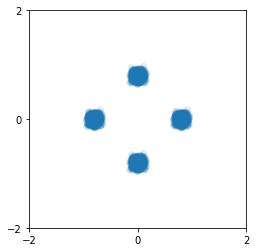

In [ ]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

Add reward

In [ ]:
def rewGau(N, mu, sigma, key):
    sg = jr.normal(key, shape=(N,1))
    g = mu + sigma * sg
    return g

In [ ]:
r1 = rewGau(2500, 5.0, 0.5, key)
r2 = rewGau(2500, 10.0, 0.5, key)
r3 = rewGau(2500, 2.0, 0.5, key)
r4 = rewGau(2500, 0.0, 0.5, key)

In [ ]:
rewards = jnp.concatenate([r1, r2, r3, r4], axis=0)

In [ ]:
rewards.shape

(10000, 1)

Join actions and rewards

In [ ]:
comb = jnp.concatenate([samples, rewards], axis=1)

In [ ]:
comb[0]

Array([0.0330051, 0.7809029, 2.9173243], dtype=float32)

In [ ]:
rewards[:,0]

(10000,)

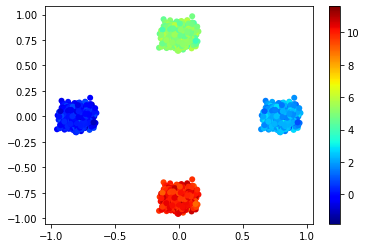

In [ ]:
points = plt.scatter(samples[:, 0], samples[:, 1], c=rewards[:,0 ],cmap="jet", lw=0)
plt.colorbar(points)

BC-Diffusion

In [ ]:
class NeuralNet(eqx.Module):
  main_net: eqx.nn.MLP
  t1: float

  def __init__(self, in_size, out_size, hidden_size, depth, key):
    (rng,) = jr.split(key, 1)
    self.main_net = eqx.nn.MLP(in_size, out_size , hidden_size, depth, key = rng)
    self.t1 = t1

  def __call__(self, t, y):
    t = t / self.t1
    t = einops.repeat(t, "-> 2")
    y = jnp.concatenate([y, t]) #axis =1
    
    y = self.main_net(y)
    return y

In [ ]:
def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    pred = model(t, y)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)

In [ ]:
def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))

In [ ]:
@eqx.filter_jit
def make_step(model, weight, int_beta, data, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, weight, int_beta, data, t1, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jr.split(key, 1)[0]
    return loss, model, key, opt_state

In [ ]:
def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm, :]
            start = end
            end = start + batch_size

In [ ]:
t1=10.0
# Optimisation hyperparameters
num_steps=20_000
lr=3e-4
batch_size=256
print_every=500
# Sampling hyperparameters
dt0=0.1
#sample_size=10
# Seed
seed=2023

In [ ]:
x = samples.copy()

In [ ]:
model_key, train_key, loader_key, sample_key = jr.split(key, 4)
data = x
data_shape = data.shape[1:]

In [ ]:
model = ActorNet(key=key)

In [ ]:
model = NeuralNet(4, 2, 512, 4, key)

In [ ]:
int_beta = lambda t: t
weight = lambda t: 1 - jnp.exp(-int_beta(t))  
opt = optax.adabelief(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

In [ ]:
total_value = 0
total_size = 0
losses = [0]
i=0
ls=2


for step, data in zip(range(num_steps), dataloader(data, batch_size, key=loader_key)):
      value, model, train_key, opt_state = make_step(model, weight, int_beta, data, t1, train_key, opt_state, opt.update)
      total_value += value.item()
      total_size += 1

      if (step % print_every) == 0 or step == num_steps - 1:
              
          print(f"Step={step} Loss={total_value / total_size}")
          if step != 0 :
              ls = total_value / total_size
              if jnp.absolute(ls - losses[i]) > 5e-5:
                  i += 1
                  losses.append(ls)
              else:
                  print("Early stopping intervened")
                  break
          else:
             continue
          total_value = 0
          total_size = 0

Step=0 Loss=1.0318974256515503
Step=500 Loss=0.08830062449424567
Step=1000 Loss=0.06027459269016981
Step=1500 Loss=0.060187305234372615
Step=2000 Loss=0.056852208368480206
Step=2500 Loss=0.054919854804873464
Step=3000 Loss=0.05472643185406923
Step=3500 Loss=0.054126452185213565
Step=4000 Loss=0.054027429059147834
Step=4500 Loss=0.0544240889325738
Step=5000 Loss=0.05411452333629131
Step=5500 Loss=0.05348319211602211
Step=6000 Loss=0.05450757291167974
Step=6500 Loss=0.0540609016418457
Step=7000 Loss=0.05452342709898949
Step=7500 Loss=0.05331638041883707
Step=8000 Loss=0.05379107251018286
Step=8500 Loss=0.0537896138727665
Early stopping intervened


In [ ]:
@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + model(t, y))

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

In [ ]:
sample_key = jr.split(sample_key, 2_000)
sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(sample_key)

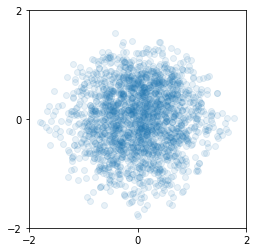

In [ ]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(sample[:, 0], sample[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

In [ ]:
# def main(
#     t1=10.0,
#     # Optimisation hyperparameters
#     num_steps=8_000,
#     lr=3e-4,
#     batch_size=256,
#     print_every=500,
#     # Sampling hyperparameters
#     dt0=0.1,
#     # Seed
#     seed=2023,
# ):
#     key = jr.PRNGKey(seed)
   
#     x = samples.copy()
#     model_key, train_key, loader_key, sample_key = jr.split(key, 4)
#     data = x
#     data_shape = data.shape[1:]

#     model = NeuralNet(4, 2, 512, 4, key)

#     int_beta = lambda t: t  
#     weight = lambda t: 1 - jnp.exp(-int_beta(t)) 
#     opt = optax.adabelief(lr)
    
#     opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

#     total_value = 0
#     total_size = 0
#     for step, data in zip(
#         range(num_steps), dataloader(data, batch_size, key=loader_key)
#     ):
#         value, model, train_key, opt_state = make_step(
#             model, weight, int_beta, data, t1, train_key, opt_state, opt.update
#         )
#         total_value += value.item()
#         total_size += 1
#         if (step % print_every) == 0 or step == num_steps - 1:
#             print(f"Step={step} Loss={total_value / total_size}")
#             total_value = 0
#             total_size = 0


Helper Functions

In [ ]:
from typing import Callable

class Lambda1(eqx.Module):
    fn: Callable
    
    def __call__(self, x, *, key=None):
        return x * jnp.tanh(self.fn(x))

In [ ]:
class SinusoidalTimEmb(eqx.Module):
    dim: int
    def __init__ (self, dim):
        self.dim = dim

    def __call__ (self, x):
          half_dim = self.dim // 2
          emb = jnp.log(10000) / (half_dim - 1)
          emb = jnp.exp(jnp.arange(half_dim) * - emb)
          emb = x[:, None] * emb[None, :]
          emb = jnp.concatenate([jnp.sin(emb), jnp.cos(emb)], axis=-1)
          return emb

Networks

In [ ]:
class ActorNet(eqx.Module):
  main_net: eqx.nn.MLP
  t1: float

  def __init__(self, in_size, out_size, hidden_size, depth, key):
    (rng,) = jr.split(key, 1)
    self.main_net = eqx.nn.MLP(in_size, out_size , hidden_size, depth, key = rng)
    self.t1 = t1

  def __call__(self, t, y):
    t = t / self.t1
    t = einops.repeat(t, "-> 2")
    y = jnp.concatenate([y, t]) #axis =1
    
    y = self.main_net(y)
    return y

In [ ]:
# class ActorNet(eqx.Module):

#     time_mlp: eqx.nn.Sequential
#     mid_layer: eqx.nn.Sequential
#     final_layer: eqx.nn.Linear
#     t_dim: int = 16
#     t1: float
#     t_embed: eqx.Module

#     def __init__ (self, *, key,):

#         keya, keyb, keyc, keyd, keye, keyf = jr.split(key, 6)
 
#         t_dim = self.t_dim
#         self.t_embed = SinusoidalTimEmb(t_dim)
#         self.time_mlp = eqx.nn.Sequential([
#             eqx.nn.Linear(t_dim, t_dim *2, key=keya),
#             Lambda1(jax.nn.softplus),
#             eqx.nn.Linear(t_dim * 2, t_dim, key=keyb)   
#         ])
        
#         input_dim = 2 + t_dim

#         self.mid_layer = eqx.nn.Sequential([
#             eqx.nn.Linear(input_dim ,256, key=keyc),
#             Lambda1(jax.nn.softplus),
#             eqx.nn.Linear(256, 256, key=keyd),
#             Lambda1(jax.nn.softplus),
#             eqx.nn.Linear(256, 256, key=keye),
#             Lambda1(jax.nn.softplus)
#         ])

#         self.final_layer = eqx.nn.Linear(256, 2, key=keyf)

#         self.t1 = t1

#     def __call__(self, t, x):
#         t = jnp.array([t])
#         new_t = t/self.t1
#         input = self.t_embed(new_t)
#         input = jnp.squeeze(input)
#         t = self.time_mlp(input)
#         x = jnp.concatenate([x, t], axis=-1)
#         x = self.mid_layer(x)

#         return self.final_layer(x)

In [ ]:
class Critic1Net(eqx.Module):
  mlp: eqx.nn.Sequential

  def __init__(self, in_size, out_size, hidden_size, key):  #hidden_size = 256
    keya, keyb, keyc, keyd = jr.split(key, 4)
    self.mlp = eqx.nn.Sequential([eqx.nn.Linear(in_size, hidden_size, key=keya),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=keyb),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=keyc),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, out_size, key=keyd)])
  def __call__(self, x):
    return self.mlp(x)

In [ ]:
class Critic1Net(eqx.Module):
    Mlp: eqx.nn.MLP

    def __init__(self, in_size, out_size, depth, hidden_size, key):
        self.Mlp = eqx.nn.MLP(in_size, out_size, hidden_size, depth, key=key)

    def __call__(self, x):
      return self.Mlp(x)

In [ ]:
class Critic2Net(eqx.Module):
    Mlp: eqx.nn.MLP

    def __init__(self, in_size, out_size, depth, hidden_size, key):
        self.Mlp = eqx.nn.MLP(in_size, out_size, hidden_size, depth, key=key)

    def __call__(self, x):
      return self.Mlp(x)

In [ ]:
class Critic2Net(eqx.Module):
  mlp: eqx.nn.Sequential

  def __init__(self, in_size, out_size, hidden_size, key):  #hidden_size = 256
    keya, keyb, keyc, keyd = jr.split(key, 4)
    self.mlp = eqx.nn.Sequential([eqx.nn.Linear(in_size, hidden_size, key=keya),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=keyb),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=keyc),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, out_size, key=keyd)])
  def __call__(self, x):
    return self.mlp(x)

Target Networks

In [ ]:
class ActorNet_T(eqx.Module):
  main_net: eqx.nn.MLP
  t1: float

  def __init__(self, in_size, out_size, hidden_size, depth, key):
    (rng,) = jr.split(key, 1)
    self.main_net = eqx.nn.MLP(in_size, out_size , hidden_size, depth, key = rng)
    self.t1 = t1

  def __call__(self, t, y):
    t = t / self.t1
    t = einops.repeat(t, "-> 2")
    y = jnp.concatenate([y, t]) #axis =1
    
    y = self.main_net(y)
    return y

In [ ]:
# class ActorNet_T(eqx.Module):

#     time_mlp: eqx.nn.Sequential
#     mid_layer: eqx.nn.Sequential
#     final_layer: eqx.nn.Linear
#     t_dim: int = 16
#     t1: float


#     def __init__ (self, *, key,):

#         keya, keyb, keyc, keyd, keye, keyf = jr.split(key, 6)
 
#         t_dim = self.t_dim

#         self.time_mlp = eqx.nn.Sequential([
#             SinusoidalTimEmb(t_dim),
#             eqx.nn.Linear(t_dim, t_dim *2, key=keya),
#             Lambda1(jax.nn.softplus),
#             eqx.nn.Linear(t_dim * 2, t_dim, key=keyb)   
#         ])
        
#         input_dim = 2 + t_dim

#         self.mid_layer = eqx.nn.Sequential([
#             eqx.nn.Linear(input_dim ,256, key=keyc),
#             Lambda1(jax.nn.softplus),
#             eqx.nn.Linear(256, 256, key=keyd),
#             Lambda1(jax.nn.softplus),
#             eqx.nn.Linear(256, 256, key=keye),
#             Lambda1(jax.nn.softplus)
#         ])

#         self.final_layer = eqx.nn.Linear(256, 2, key=keyf)

#         self.t1 = t1

#     def __call__(self, t, x):
#         new_t = t/self.t1
#         t = self.time_mlp(new_t)
#         x = jnp.concatenate([x, t], axis=-1)
#         x = self.mid_layer(x)

#         return self.final_layer(x)

In [ ]:
class Critic1Net_T(eqx.Module):
  mlp: eqx.nn.Sequential

  def __init__(self, in_size, out_size, hidden_size, key):  #hidden_size = 256
    keya, keyb, keyc, keyd = jr.split(key, 4)
    self.mlp = eqx.nn.Sequential([eqx.nn.Linear(in_size, hidden_size, key=keya),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=keyb),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=keyc),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, out_size, key=keyd)])
  def __call__(self, x):
    return self.mlp(x)

In [ ]:
class Critic2Net_T(eqx.Module):
  mlp: eqx.nn.Sequential

  def __init__(self, in_size, out_size, hidden_size, key):  #hidden_size = 256
    keya, keyb, keyc, keyd = jr.split(key, 4)
    self.mlp = eqx.nn.Sequential([eqx.nn.Linear(in_size, hidden_size, key=keya),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=keyb),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, hidden_size, key=keyc),
                                  Lambda1(jax.nn.softplus),
                                  eqx.nn.Linear(hidden_size, out_size, key=keyd)])
  def __call__(self, x):
    return self.mlp(x)

In [ ]:
class Critic1Net_T(eqx.Module):
    Mlp: eqx.nn.MLP

    def __init__(self, in_size, out_size, depth, hidden_size, key):
        self.Mlp = eqx.nn.MLP(in_size, out_size, hidden_size, depth, key=key)

    def __call__(self, x):
      return self.Mlp(x)

In [ ]:
class Critic2Net_T(eqx.Module):
    Mlp: eqx.nn.MLP

    def __init__(self, in_size, out_size, depth, hidden_size, key):
        self.Mlp = eqx.nn.MLP(in_size, out_size, hidden_size, depth, key=key)

    def __call__(self, x):
      return self.Mlp(x)

Target Functions

In [ ]:

def ema(new_weight: jax.Array, target_weight: jax.Array, beta: float) -> jax.Array:
  update_w = target_weight * beta + (1 - beta)* new_weight
  return update_w


def EMA_w_update(current_model, target_model, init_fn, beta):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  
  get_weights = lambda m: [x.weight
                           for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                           if is_linear(x)]
  new_weights = get_weights(current_model)
  target_weights = get_weights(target_model)
  updated_weights = [init_fn(n_weight, t_weight, beta) for n_weight, t_weight in zip(new_weights, target_weights)]
  new_model = eqx.tree_at(get_weights, target_model, updated_weights)

  return new_model


def EMA_b_update(current_model, target_model, init_fn, beta):
  is_linear = lambda x: isinstance(x, eqx.nn.Linear)
  get_biases = lambda m: [x.bias
                          for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                          if is_linear(x)]
  new_biases = get_biases(current_model)
  target_biases = get_biases(target_model)
  updated_biases = [init_fn(c_bias, t_bias, beta) for c_bias, t_bias in zip(new_biases, target_biases)]
  new_model = eqx.tree_at(get_biases, target_model, updated_biases)

  return new_model


In [ ]:
def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    pred = model(t, y)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)

In [ ]:
def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))

In [ ]:
@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + model(t, y))

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1)
    return sol.ys[0]

Test - ignore

In [ ]:
eg = jr.normal(key, shape=(2,))

In [ ]:
Q1 = Critic1Net(2, 1, 256, key1)

In [ ]:
Q2 = Critic2Net(2, 1, 256, key2)

In [ ]:
Q2(eg)

Array([-0.01144345], dtype=float32)

In [ ]:
new_w = EMA_w_update(Q1, Q2, ema, 0.5)

In [ ]:
new_b = EMA_b_update(Q1, Q2, ema, 0.5)

Parameters

In [ ]:
iterations = 2  #100
data = comb
batch_size =256
t1 = 10.0
dt0 = 0.1
data_shape  = (2,)
discount = 0.99
lr = 3e-4
eta = 1.0  #q learning weight

update_ema_every = 5
beta = 0.995  #update policy network parameter
#tau = 0.005   #update critic network parameter

In [ ]:
int_beta = lambda t: t
weight = lambda t: 1 - jnp.exp(-int_beta(t))  

Initilialisations

In [ ]:
key1, key2, key3 = jr.split(key, 3)

In [ ]:
# c_Q1 = Critic1Net(2, 1, 4, 256, key1)
# c_Q2 = Critic2Net(2, 1, 4, 256, key2)

# t_Q1 = Critic1Net_T(2, 1, 4, 256, key1)
# t_Q2 = Critic2Net_T(2, 1, 4, 256, key2)

In [ ]:
c_Q1 = Critic1Net(2, 1, 256, key1)
c_Q2 = Critic2Net(2, 1, 256, key2)

t_Q1 = Critic1Net_T(2, 1, 256, key1)
t_Q2 = Critic2Net_T(2, 1, 256, key2)

In [ ]:
# c_pi = ActorNet(key=key3)
# t_pi = ActorNet_T(key=key3)

In [ ]:
c_pi = ActorNet(4, 2, 256, 4, key=key3)
t_pi = ActorNet_T(4, 2, 256, 4, key=key3)

In [ ]:
opt = optax.adabelief(lr)


opt_state_1 = opt.init(eqx.filter(c_Q1, eqx.is_inexact_array))
opt_state_2 = opt.init(eqx.filter(c_Q2, eqx.is_inexact_array))

# opt_state_q1t = opt.init(eqx.filter(t_Q1, eqx.is_inexact_array))
# opt_state_q2t = opt.init(eqx.filter(t_Q2, eqx.is_inexact_array))

opt_state_cpi = opt.init(eqx.filter(c_pi, eqx.is_inexact_array))
#opt_state_tpi = opt.init(eqx.filter(t_pi, eqx.is_inexact_array))

# clip = optax.clip_by_global_norm(1.0)

# c_opt= optax.chain(clip, opt)

In [ ]:
clip = optax.clip_by_global_norm(1.0)

c_opt= optax.chain(clip, opt)

Train

In [ ]:
# def c_loss(c_Qa, c_Qb, action, target_q):
#     current_qa = jax.vmap(c_Qa)(action)
#     current_qb = jax.vmap(c_Qb)(action)
    
#     targ = lambda x: jax.lax.stop_gradient(reward + discount * x)

#     return jnp.mean((current_qa - targ(target_q))**2) + jnp.mean((current_qb - targ(target_q))**2)

In [ ]:
# def p_loss(c_pi, new_q1_action, new_q2_action, action, u_key, actor_key):
    
#     ql = lambda x,y : jax.lax.stop_gradient(- jnp.mean(x) / jnp.mean(jnp.absolute(y)))

#     if jr.uniform(u_key, shape = ()) > 0.5:
#         q_loss = ql(new_q1_action, new_q2_action)
#         testlst1.append("hi")
#     else:
#         q_loss = ql(new_q2_action, new_q1_action)
#         testlst1.append("bye")
    
#     bc_loss = batch_loss_fn(c_pi, weight, int_beta, action, t1, actor_key)
#     actor_loss = bc_loss + eta * q_loss
#     return actor_loss

In [ ]:
# model_key, train_key, loader_key, sample_key, actor_key, pls_key = jr.split(key, 6)

In [ ]:
# testlst1 = []
# step=0
# for _ in range(iterations):

    
#     dataset_size = data.shape[0]
#     indices = jnp.arange(dataset_size)
#     perm = jr.permutation(perm_key, indices)
#     perm_key = jr.split(perm_key, 1)[0]   #perm_key = jr.split(key, 1)[0]
#     p = perm[0:batch_size]
#     dat = data[p]
#     action, reward = jnp.split(dat, [2], axis=1)



#     """Q-Training"""   

#     alpha_key = jr.split(n_act_key, batch_size)
#     sample_fn = ft.partial(single_sample_fn, t_pi, int_beta, data_shape , dt0, t1)
#     next_action = jax.vmap(sample_fn)(alpha_key)
#     n_act_key = jr.split(n_act_key, 1)[0]

        
#     t_1 = jax.vmap(t_Q1)(next_action)
#     t_2 = jax.vmap(t_Q2)(next_action)

        
#     target_q = jnp.minimum(t_1, t_2)


#     loss_fn = eqx.filter_value_and_grad(c_loss)


#     loss1, grads1 = loss_fn(c_Q1, c_Q2, action, target_q)
#     loss2, grads2 = loss_fn(c_Q2, c_Q1, action, target_q)
    
#     updates1, opt_state1 = opt.update(grads1, opt_state_1)
#     updates2, opt_state2 = opt.update(grads2, opt_state_2)

#     c_Q1 = eqx.apply_updates(c_Q1, updates1)
#     c_Q2 = eqx.apply_updates(c_Q2, updates2)

#     """Policy Training"""

#     beta_key = jr.split(p_act_key, batch_size)
#     sample_fn = ft.partial(single_sample_fn, c_pi, int_beta, data_shape , dt0, t1)
#     new_action = jax.vmap(sample_fn)(beta_key)
#     p_act_key = jr.split(p_act_key, 1)[0]


#     new_q1_action = jax.vmap(c_Q1)(new_action)
#     new_q2_action = jax.vmap(c_Q2)(new_action)

#     # if jr.uniform(u_key, shape = ()) > 0.5:
#     #     q_loss = - jnp.mean(new_q1_action) / jnp.mean(jnp.absolute(new_q2_action))
#     # else:
#     #     q_loss = - jnp.mean(new_q2_action) / jnp.mean(jnp.absolute(new_q1_action))

  
#     #u_key = jr.split(u_key, 1)[0]


#     loss_fn = eqx.filter_value_and_grad(p_loss)

#     loss, grads = loss_fn(c_pi, new_q1_action, new_q2_action, action, u_key, actor_key)
#     updates, opt_state_cpi = opt.update(grads, opt_state_cpi)
#     c_pi = eqx.apply_updates(c_pi, updates)
#     actor_key = jr.split(actor_key, 1)[0]
#     u_key = jr.split(u_key, 1)[0]


#     """Update Target Networks"""

#     if _ % update_ema_every == 0:
        
#         t_Q1 = EMA_w_update(c_Q1, t_Q1, ema, beta)
#         t_Q2 = EMA_w_update(c_Q2, t_Q2, ema, beta)
        
#         t_Q1 = EMA_b_update(c_Q1, t_Q1, ema, beta)
#         t_Q2 = EMA_b_update(c_Q2, t_Q2, ema, beta)
        
#         t_pi = EMA_w_update(c_pi, t_pi, ema, beta)
#         t_pi = EMA_b_update(c_pi, t_pi, ema, beta)

#         #print(step)
#     else:
#         continue

#     step += 1
#     #print(step)

In [ ]:
def critic_loss(c_Qa, c_Qb, t_pi, t_Q1, t_Q2, action, reward, n_act_key):
    current_qa = jax.vmap(c_Qa)(action)
    current_qb = jax.vmap(c_Qb)(action)
    
    
    
    alpha_key = jr.split(n_act_key, batch_size)
    sample_fn = ft.partial(single_sample_fn, t_pi, int_beta, data_shape , dt0, t1)
    next_action = jax.vmap(sample_fn)(alpha_key)



        
    t_1 = jax.vmap(t_Q1)(next_action)
    t_2 = jax.vmap(t_Q2)(next_action)

        
    target_q = jnp.minimum(t_1, t_2)
    
    
    target_q = reward + (discount * target_q)
    
    return jnp.mean( ( current_qa - target_q )**2) + jnp.mean( ( current_qb - target_q )**2)

In [ ]:
def actor_loss(c_pi, c_Q1, c_Q2, action, u_key, p_act_key, actor_key):
    beta_key = jr.split(p_act_key, batch_size)
    sample_fn = ft.partial(single_sample_fn, c_pi, int_beta, data_shape , dt0, t1)
    new_action = jax.vmap(sample_fn)(beta_key)

    new_q1_action = jax.vmap(c_Q1)(new_action)
    new_q2_action = jax.vmap(c_Q2)(new_action)

    if jr.uniform(u_key, shape = ()) > 0.5:
        q_loss = - jnp.mean(new_q1_action) / jnp.mean(jnp.absolute(new_q2_action))
    else:
        q_loss = - jnp.mean(new_q2_action) / jnp.mean(jnp.absolute(new_q1_action))


    bc_loss = batch_loss_fn(c_pi, weight, int_beta, action, t1, actor_key)
    
    return bc_loss + (eta * q_loss)

    

In [ ]:
perm_key, n_act_key, p_act_key, u_key, actor_key = jr.split(key, 5)

In [ ]:
#testlst1 = []
step=0
for _ in range(iterations):

    
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    perm = jr.permutation(perm_key, indices)
    perm_key = jr.split(perm_key, 1)[0]   #perm_key = jr.split(key, 1)[0]
    p = perm[0:batch_size]
    dat = data[p]
    action, reward = jnp.split(dat, [2], axis=1)



    """Q-Training"""   


    loss_fn = eqx.filter_value_and_grad(critic_loss)


    loss1, grads1 = loss_fn(c_Q1, c_Q2, t_pi, t_Q1, t_Q2, action, reward, n_act_key)
    loss2, grads2 = loss_fn(c_Q2, c_Q1, t_pi, t_Q1, t_Q2, action, reward, n_act_key)
    
    updates1, opt_state1 = opt.update(grads1, opt_state_1)
    updates2, opt_state2 = opt.update(grads2, opt_state_2)

    c_Q1 = eqx.apply_updates(c_Q1, updates1)
    c_Q2 = eqx.apply_updates(c_Q2, updates2)

    n_act_key = jr.split(n_act_key, 1)[0]
    
    
    """Policy Training"""


   

    loss_fn = eqx.filter_value_and_grad(actor_loss)
    
    loss, grads = loss_fn(c_pi, c_Q1, c_Q2, action, u_key, p_act_key, actor_key)
    updates, opt_state_cpi = opt.update(grads, opt_state_cpi)
    c_pi = eqx.apply_updates(c_pi, updates)
    
    
    
    actor_key = jr.split(actor_key, 1)[0]
    u_key = jr.split(u_key, 1)[0]
    p_act_key = jr.split(p_act_key, 1)[0]


    """Update Target Networks"""

    if _ % update_ema_every == 0:
        
        t_Q1 = EMA_w_update(c_Q1, t_Q1, ema, beta)
        t_Q2 = EMA_w_update(c_Q2, t_Q2, ema, beta)
        
        t_Q1 = EMA_b_update(c_Q1, t_Q1, ema, beta)
        t_Q2 = EMA_b_update(c_Q2, t_Q2, ema, beta)
        
        t_pi = EMA_w_update(c_pi, t_pi, ema, beta)
        t_pi = EMA_b_update(c_pi, t_pi, ema, beta)


    else:
        continue

    step += 1
 

In [ ]:
optax.global_norm(grads)

Array(2.9185402, dtype=float32)

Sample

In [ ]:
(new_key,) = jr.split(key, 1)

In [ ]:
s_key = jr.split(new_key, 2_000)
sample_fn = ft.partial(single_sample_fn, c_pi, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(s_key)

In [ ]:
new_s = jnp.clip(sample, -2.0, 2.0)

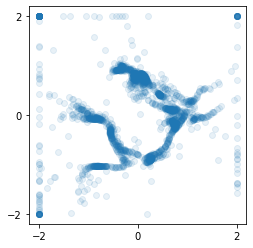

In [ ]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(new_s[:, 0], new_s[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

New sample

In [ ]:
(new_key,) = jr.split(key, 1)

In [ ]:
s_key = jr.split(new_key, 2_000)
sample_fn = ft.partial(single_sample_fn, c_pi, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(s_key)

In [ ]:
new_s = jnp.clip(sample, -2.0, 2.0)

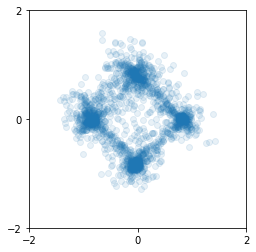

In [ ]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(new_s[:, 0], new_s[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

Even newer sample

In [ ]:
(new_key,) = jr.split(key, 1)

In [ ]:
s_key = jr.split(new_key, 150)
sample_fn = ft.partial(single_sample_fn, c_pi, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(s_key)

In [ ]:
new_s = jnp.clip(sample, -2.0, 2.0)

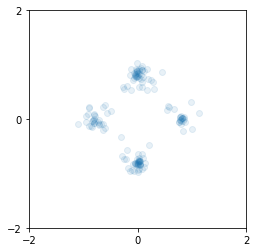

In [ ]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(new_s[:, 0], new_s[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

Even newer sample

In [ ]:
(new_key,) = jr.split(key, 1)

In [ ]:
s_key = jr.split(new_key, 500)
sample_fn = ft.partial(single_sample_fn, c_pi, int_beta, data_shape, dt0, t1)
sample = jax.vmap(sample_fn)(s_key)

In [ ]:
new_s = jnp.clip(sample, -2.0, 2.0)

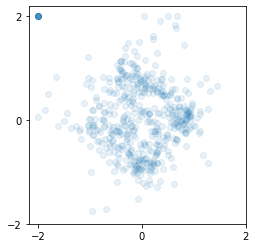

In [ ]:
plt.figure().add_subplot(111).set_aspect("equal", adjustable="box")
plt.scatter(new_s[:, 0], new_s[:, 1], alpha=0.1) #plot 1st row as x values and 2nd row as y values on the plot
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.show()

In [ ]:
t_Q1(jnp.array([0.0, 0.8]))

Array([1317060.5], dtype=float32)

In [ ]:
c_Q1(jnp.array([0.0, 0.8]))

Array([23446844.], dtype=float32)

In [ ]:
t_Q2(jnp.array([0.0, 0.8]))

Array([1286689.8], dtype=float32)

In [ ]:
c_Q2(jnp.array([0.0, 0.8]))

Array([22416152.], dtype=float32)

In [ ]:
t_Q1(jnp.array([8.0, 0.0]))

Array([261.67404], dtype=float32)

In [ ]:
c_Q1(jnp.array([8.0, 0.0]))

Array([267.49957], dtype=float32)

In [ ]:
t_Q2(jnp.array([8.0, 0.0]))

Array([441.79007], dtype=float32)

In [ ]:
c_Q1(jnp.array([8.0, 0.0]))

Array([267.49957], dtype=float32)